In [1]:
! pip install awswrangler

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
  Using cached awswrangler-2.10.0-py3-none-any.whl (184 kB)
  Using cached pg8000-1.20.0-py3-none-any.whl (34 kB)
  Using cached openpyxl-3.0.7-py2.py3-none-any.whl (243 kB)
  Using cached redshift_connector-2.0.884-py3-none-any.whl (94 kB)
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
  Using cached scramp-1.4.0-py3-none-any.whl (8.4 kB)
  Using cached lxml-4.6.3-cp36-cp36m-manylinux2014_x86_64.whl (6.3 MB)
  Using cached asn1crypto-1.4.0-py2.py3-none-any.whl (104 kB)
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [2]:
import awswrangler as wr
import pandas as pd
import pytz
from scipy.stats import zscore
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import quantile_transform
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold

## Preparing Data

### Data for chemistry variables

- From 16-04-2020 to 09-06-2021


In [3]:
p = 's3://brains-osum-dev-standard-s3/scovan-data/Osum Data/PI Historian Data/pi-historian-consolidated-09062021.csv'
df = wr.s3.read_csv(path=p, parse_dates=["time"])[['time', 'tag', 'value']]
                                    

In [4]:
df['time'] = pd.to_datetime(df['time']) 
df = df.set_index('time')
df['value'] = pd.to_numeric(df['value'], errors='coerce') 

In [5]:
req_tags = ['OR-OP-T3005_Evap feed TK-H2O test_hardness',
 'OR-OP-T3005_Evap feed TK-H2O test_iron',
 'OR-OP-Evap feed-H2O test_silica',
 'OR-OP-T3005_Evap feed TK-H2O test_pH',
 'OR-OP-T3005_Evap feed TK-H2O test_conductivity',
 'OR-OP-De-Oil_Prod H2O_Turbidity ORF outlet',
           'OR-OP_PIT_3194.PV']

grouped = df.groupby(df.tag)
df_tag_wc = {}
df_tag_wc_fill = {}
for tag in req_tags:    
    temp_df = grouped.get_group(tag)
    df_tag_wc[tag] = temp_df['2018-01-08': '2020-11-22'].copy()  #'2018-01-08': '2020-11-22'  
    temp_df = temp_df.resample('4H').ffill().bfill()
    df_tag_wc_fill[tag] = temp_df['2018-01-08': '2020-11-22'].copy()


In [6]:
req_tags_chem = ['OR-OP-T3005_Evap feed TK-H2O test_hardness',
 'OR-OP-T3005_Evap feed TK-H2O test_iron',
 'OR-OP-Evap feed-H2O test_silica',
 'OR-OP-T3005_Evap feed TK-H2O test_pH',
 'OR-OP-T3005_Evap feed TK-H2O test_conductivity',
 'OR-OP-De-Oil_Prod H2O_Turbidity ORF outlet',
            'OR-OP_PIT_3194.PV',     
           'OR-OP_FIT_3910.PV',
            'OR-OP_FIT_3452C.PV']

# grouped = df.groupby(df.tag)
df_tag_chem = {}
df_tag_chem_fill = {}
for tag in req_tags_chem:    
    temp_df = grouped.get_group(tag)
    df_tag_chem[tag] = temp_df['2019-02-16': '2020-11-22'].copy()  #'2018-01-08': '2020-11-22' 
    temp_df = temp_df.resample('4H').ffill().bfill()
    df_tag_chem_fill[tag] = temp_df['2019-02-16': '2020-11-22'].copy()
    
    


In [7]:
def get_col_names_dict(df_tag, col_names):
    match_dict = {}
    i = 0   
    for key in df_tag.keys():
        match_dict[col_names[i]] = key
        i = i + 1
    return match_dict 
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','EDTA', 'CAU']
match_dict_chem = get_col_names_dict(df_tag_chem, col_names)
print(match_dict_chem)


{'hardness': 'OR-OP-T3005_Evap feed TK-H2O test_hardness', 'iron': 'OR-OP-T3005_Evap feed TK-H2O test_iron', 'silica': 'OR-OP-Evap feed-H2O test_silica', 'ph': 'OR-OP-T3005_Evap feed TK-H2O test_pH', 'conductivity': 'OR-OP-T3005_Evap feed TK-H2O test_conductivity', 'turbidity': 'OR-OP-De-Oil_Prod H2O_Turbidity ORF outlet', 'P1': 'OR-OP_PIT_3194.PV', 'EDTA': 'OR-OP_FIT_3910.PV', 'CAU': 'OR-OP_FIT_3452C.PV'}


In [8]:
col_names_wc = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','U1','U2', 'U3', 'U4']
match_dict_wc = get_col_names_dict(df_tag_wc, col_names_wc)
print(match_dict_wc)

{'hardness': 'OR-OP-T3005_Evap feed TK-H2O test_hardness', 'iron': 'OR-OP-T3005_Evap feed TK-H2O test_iron', 'silica': 'OR-OP-Evap feed-H2O test_silica', 'ph': 'OR-OP-T3005_Evap feed TK-H2O test_pH', 'conductivity': 'OR-OP-T3005_Evap feed TK-H2O test_conductivity', 'turbidity': 'OR-OP-De-Oil_Prod H2O_Turbidity ORF outlet', 'P1': 'OR-OP_PIT_3194.PV'}


### Data for chemistry variables

- U value from 

In [9]:
df_evapuvalue = pd.read_csv('evap_uval.csv')
df_evapuvalue['time'] = pd.to_datetime(df_evapuvalue['time']) 
df_evapuvalue = df_evapuvalue.set_index('time')
df_evapuvalue_copy = df_evapuvalue.copy()
for column in df_evapuvalue.columns:
    df_evapuvalue[column] = pd.to_numeric(df_evapuvalue[column], errors='coerce') 

mountain = pytz.timezone('Canada/Saskatchewan')
df_evapuvalue.index = df_evapuvalue.index.tz_localize(pytz.utc).tz_convert(mountain)

In [10]:
df_evapuvalue_2018 = df_evapuvalue.resample('4H').ffill().bfill()
df_evapuvalue_2018_wc = df_evapuvalue_2018['2018-01-08': '2020-11-22'].copy()
df_evapuvalue_2018_chem = df_evapuvalue_2018['2019-02-16': '2020-11-22'].copy()

In [11]:
# col_names_wc = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','U1','U2', 'U3', 'U4']
u_dict_wc ={} 
u_dict_chem ={} 
for value in ['U1','U2', 'U3', 'U4']:    
    u = pd.DataFrame()
    u[value] = df_evapuvalue_2018_wc[value].copy() 
    u_dict_wc[value]  = u
    u_chem = pd.DataFrame()
    u_chem[value] = df_evapuvalue_2018_chem[value].copy()
    u_dict_chem[value]  = u_chem
# df_combined_wc['U2'] = df_evapuvalue_2018_wc['U2'].copy() 
# df_combined_wc['U3'] = df_evapuvalue_2018_wc['U3'].copy()
# df_combined_wc['U4'] = df_evapuvalue_2018_wc['U4'].copy() 

In [14]:
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','EDTA', 'CAU','U1','U2', 'U3', 'U4']
df_combined = pd.DataFrame(columns = col_names)
df_combined['U1'] = df_evapuvalue_2018_chem['U1'].copy() 
df_combined['U2'] = df_evapuvalue_2018_chem['U2'].copy() 
df_combined['U3'] = df_evapuvalue_2018_chem['U3'].copy()
df_combined['U4'] = df_evapuvalue_2018_chem['U4'].copy() 

In [15]:
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','EDTA', 'CAU','U1','U2', 'U3', 'U4']
for name in col_names[:-4]:
#     print(name)
    df_combined[name] = df_tag_chem_fill[match_dict_chem[name]]['value'].values.copy()
df_round = df_combined.round(2).copy()
z_scores = zscore(df_combined)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

new_df_sd = df_round[filtered_entries].copy()
new_df_sd['ph'].clip(upper=10.5, inplace = True)

In [16]:
new_df_sd

,hardness,iron,silica,ph,conductivity,turbidity,EDTA,CAU,U1,U2,U3,U4
time,,,,,,,,,,,,
2019-02-16 00:00:00-06:00,9.35,0.0,465.0,10.50,3504.0,8.00,30.54,-2.47,2165.92,2469.21,4547.67,9208.42
2019-02-16 04:00:00-06:00,9.35,0.0,465.0,10.50,3504.0,8.00,30.20,-2.47,2205.59,2438.29,5124.65,9201.35
2019-02-16 08:00:00-06:00,9.35,0.0,465.0,10.50,3504.0,8.00,30.38,-2.47,2210.45,2536.59,5631.89,9146.30
2019-02-16 12:00:00-06:00,9.35,0.0,465.0,10.50,3504.0,8.00,29.93,-2.47,2254.11,2526.84,3178.36,9215.25
2019-02-16 16:00:00-06:00,9.35,0.0,465.0,10.50,3504.0,8.00,30.28,-2.47,2232.38,2518.55,5055.33,9435.72
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-12 04:00:00-06:00,10.00,0.4,371.0,7.27,5541.0,7.33,32.90,74.77,1672.74,1933.00,1681.47,3154.82
2020-11-12 08:00:00-06:00,10.00,0.4,371.0,7.27,5541.0,7.33,34.61,97.37,1688.87,1823.36,1662.82,3233.10
2020-11-12 12:00:00-06:00,10.00,0.4,482.0,7.34,5409.0,34.67,44.72,89.73,1689.07,1773.30,1589.89,3277.05


### Plot help functions

In [17]:
import matplotlib.pyplot as plt
def plot_hist(df, tag, title):
    plt.hist(df[tag], bins=50, alpha=0.5,
                    range=[df[tag].min(), df[tag].max()],
                      facecolor='gray', align='mid')
    plt.title(title, fontsize=10, fontweight='bold')
    plt.show()


In [18]:
def plot_hist_time(df, tag, title):
    plt.plot(df.index, df[tag])
    plt.title(title, fontsize=10, fontweight='bold')
    plt.show()

### Preparing data frames

- df_merged refers to dataframe where water chemistry variables along with U values mapped with tolerence of 7D
- df_merged_1d refers to dataframe where water chemistry variables along with U values mapped with tolerence of 1D
- df_merged_chem refers to dataframe where water chemistry variables, EDTA and CAU along with U values mapped with tolerence of 7D 

In [14]:
from functools import reduce
data_frames = []
for item in df_tag_wc.values():
    mountain = pytz.timezone('Canada/Saskatchewan')
    item.index = item.index.tz_localize(pytz.utc).tz_convert(mountain)
    data_frames.append(item['value'])
# df_U1 = df_U1.tz_localize(pytz.utc).tz_convert(mountain) 
for value in u_dict_wc.values():
    data_frames.append(value)
df_merged = reduce(lambda  left, right: pd.merge_asof(left, right, on="time", 
                                                      tolerance=pd.Timedelta("7D")),data_frames)
df_merged.set_index('time', inplace=True)
df_merged.columns = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','U1','U2', 'U3', 'U4'] 
df_merged.dropna(inplace=True)

In [15]:
df_merged_1d = reduce(lambda  left, right: pd.merge_asof(left, right, on="time", 
                                                      tolerance=pd.Timedelta("1D")),data_frames)
df_merged_1d.set_index('time', inplace=True)
df_merged_1d.columns = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','U1','U2', 'U3', 'U4'] 
df_merged_1d.dropna(inplace=True)

In [16]:
df_merged_1d

,hardness,iron,silica,ph,conductivity,turbidity,P1,U1,U2,U3,U4
time,,,,,,,,,,,
2018-04-07 11:33:06-06:00,22.0,0.26,0.0,7.68,3621.0,6.00,125.35577,2485.410918,2782.945099,3941.992734,6160.716116
2018-04-07 23:26:52-06:00,60.0,0.26,500.0,7.74,3621.0,6.00,125.95937,2448.412565,2734.961874,3941.992734,6160.716116
2018-05-20 23:10:09-06:00,18.0,0.64,356.0,8.91,4590.0,7.00,114.54992,1667.089691,3667.846940,1478.946939,6160.716116
2018-05-31 08:37:39-06:00,24.0,0.32,360.0,8.14,3587.0,14.00,127.27451,1866.371029,3262.608048,3756.717391,6160.716116
2018-06-26 22:55:07-06:00,13.0,0.19,419.0,8.00,3809.0,9.00,127.41192,1962.528558,3027.018041,3651.862133,6160.716116
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-05 05:28:41-06:00,10.0,0.70,316.0,7.29,5280.0,12.67,123.35360,2049.094982,1739.118587,2826.389302,2720.067983
2020-11-05 18:24:23-06:00,15.0,0.56,273.0,7.61,3820.0,44.33,122.99050,2002.254272,1722.937719,2358.231145,3192.854904
2020-11-08 04:12:54-06:00,32.0,0.17,315.0,7.06,4645.0,4.33,126.17036,1636.005045,1887.252573,368.561787,4017.344497


In [17]:
from functools import reduce
data_frames = []
for item in df_tag_chem.values():
    mountain = pytz.timezone('Canada/Saskatchewan')
    item.index = item.index.tz_localize(pytz.utc).tz_convert(mountain)
    data_frames.append(item['value'])
for value in u_dict_chem.values():
    data_frames.append(value)

df_merged_chem = reduce(lambda  left, right: pd.merge_asof(left, right, on="time", 
                                                      tolerance=pd.Timedelta("7D")),data_frames)
df_merged_chem.set_index('time', inplace=True)
df_merged_chem.columns = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','EDTA', 'CAU','U1','U2', 'U3', 'U4'] 
df_merged_chem.dropna(inplace=True)

In [41]:
df_merged_chem

,hardness,iron,silica,ph,conductivity,turbidity,EDTA,CAU,U1,U2,U3,U4
time,,,,,,,,,,,,
2019-03-10 23:46:36-06:00,20.0,0.19,295.0,7.87,5800.0,6.00,24.900475,-2.273768,2177.224319,2466.746452,4881.749965,9261.949326
2019-04-19 05:20:49-06:00,18.0,0.21,413.0,8.52,4649.0,49.00,19.162487,-2.371967,2292.529220,2141.236784,3599.235027,6913.222611
2019-04-29 23:29:51-06:00,14.0,0.23,365.0,8.54,4980.0,14.00,21.257309,-2.666414,2335.258710,2266.876289,3941.992734,5900.437082
2019-05-06 19:00:52-06:00,18.0,0.80,220.0,8.02,4649.0,6.67,22.110001,-2.666414,2182.385154,2354.941985,5107.704697,4793.805277
2019-05-07 17:20:22-06:00,0.0,3.10,220.0,8.06,4649.0,6.67,22.537127,-2.568215,2369.045797,2300.487466,3941.992734,4972.052636
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17 11:02:22-06:00,16.0,0.22,260.0,7.53,5335.0,236.67,55.923940,42.666770,2374.175002,2100.804334,3941.992734,4306.628007
2020-11-17 16:54:24-06:00,18.0,0.36,330.0,7.82,6634.0,236.67,57.348230,45.795180,2285.908199,2091.182868,3450.321423,3439.959125
2020-11-18 11:08:21-06:00,15.0,0.42,350.0,7.56,5455.0,236.67,65.463700,41.243680,2201.784194,2034.341356,5422.053377,3542.867871


## Adding Additional features 

In [18]:
df_round_wc = df_merged.round(2).copy()
z_scores = zscore(df_merged)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

new_df_sd_wc = df_round_wc[filtered_entries].copy()
new_df_sd_wc['ph'].clip(upper=10.5, inplace = True)

In [19]:
df_round_wc_1d = df_merged_1d.round(2).copy()
z_scores = zscore(df_merged_1d)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

new_df_sd_wc_1d = df_round_wc_1d[filtered_entries].copy()
new_df_sd_wc_1d['ph'].clip(upper=10.5, inplace = True)

In [20]:
df_round_chem = df_merged_chem.round(2).copy()
z_scores = zscore(df_merged_chem)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

new_df_sd_chem = df_round_chem[filtered_entries].copy()
new_df_sd_chem['ph'].clip(upper=10.5, inplace = True)

In [22]:
new_df_sd_wc['P1d'] = new_df_sd_wc['P1'].diff()
new_df_sd_wc['Time_diff'] = (pd.to_timedelta(new_df_sd_wc.index.to_series().diff())
                     .dt.total_seconds()
                     .div(3600))
new_df_sd_wc['U1rt'] = new_df_sd_wc['U1'].diff()/new_df_sd_wc['Time_diff']
new_df_sd_wc['U1rrt'] = new_df_sd_wc['U1rt'].diff()/new_df_sd_wc['Time_diff']

new_df_sd_wc.dropna(inplace=True)

In [23]:
new_df_sd_wc_1d['P1d'] = new_df_sd_wc_1d['P1'].diff()
new_df_sd_wc_1d['Time_diff'] = (pd.to_timedelta(new_df_sd_wc_1d.index.to_series().diff())
                     .dt.total_seconds()
                     .div(3600))
new_df_sd_wc_1d['U1rt'] = new_df_sd_wc_1d['U1'].diff()/new_df_sd_wc_1d['Time_diff']
new_df_sd_wc_1d['U1rrt'] = new_df_sd_wc_1d['U1rt'].diff()/new_df_sd_wc_1d['Time_diff']
new_df_sd_wc_1d.dropna(inplace=True)

In [45]:
new_df_sd_chem

,hardness,iron,silica,ph,conductivity,turbidity,P1,EDTA,CAU,U1,U2,U3,U4
time,,,,,,,,,,,,,
2019-04-19 05:20:49-06:00,18.0,0.21,413.0,8.52,4649.0,49.00,113.80,19.16,-2.37,2292.53,2141.24,3599.24,6913.22
2019-04-29 23:29:51-06:00,14.0,0.23,365.0,8.54,4980.0,14.00,114.96,21.26,-2.67,2335.26,2266.88,3941.99,5900.44
2019-05-06 19:00:52-06:00,18.0,0.80,220.0,8.02,4649.0,6.67,116.43,22.11,-2.67,2182.39,2354.94,5107.70,4793.81
2019-05-07 17:20:22-06:00,0.0,3.10,220.0,8.06,4649.0,6.67,117.37,22.54,-2.57,2369.05,2300.49,3941.99,4972.05
2019-05-08 16:18:35-06:00,15.0,3.10,220.0,8.09,4649.0,14.00,117.11,20.57,-2.67,2240.85,2169.08,5059.83,4925.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-07 16:14:00-06:00,25.0,0.17,315.0,7.29,4645.0,30.67,125.89,51.17,71.61,1737.50,2024.47,2293.26,6752.59
2020-11-08 04:12:54-06:00,32.0,0.17,315.0,7.06,4645.0,4.33,126.17,65.10,64.52,1636.01,1887.25,368.56,4017.34
2020-11-10 23:45:48-06:00,5.0,0.35,217.0,8.11,5110.0,7.33,126.67,36.79,40.13,1607.21,1918.27,585.54,3742.45


In [20]:
!pip install seaborn

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [ ]:
new_df_sd

### U1 Data in Gaussian States

In [21]:
import seaborn as sns
from matplotlib import cm
from matplotlib.dates import YearLocator, MonthLocator
def markov_plot(new_df_sd_chem, model, col_names, title):
    print("Means and vars of each hidden state")
    for i in range(model.n_components):
        print("{0}th hidden state".format(i))
        print("mean = ", model.means_[i])
        try:
            print("var = ", np.diag(model.covariances_[i]))
        except:
            continue
    hidden_states = model.predict(X)
    sns.set(font_scale=1.25)
    style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
                  'font.family':u'courier prime code', 'legend.frameon': True}
    sns.set_style('white', style_kwds)

    order = range(0, model.n_components) 
    sns.set(font_scale=1.25)
    style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
                  'font.family':u'courier prime code', 'legend.frameon': True}
    sns.set_style('white', style_kwds)

    fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
    colors = cm.rainbow(np.linspace(0, 1, model.n_components))

    for i, (ax, color) in enumerate(zip(axs, colors)):
        # Use fancy indexing to plot data in each state.
        mask = hidden_states == i
        ax.plot_date(new_df_sd_chem.index.values[mask],
                     new_df_sd_chem['U1'].values[mask],
                     ".-", c=color)
        ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

        # Format the ticks.
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        sns.despine(offset=10)

    plt.tight_layout()

    sns.set(font_scale=1.5)
    states = new_df_sd_chem[col_names].copy()
    states['state'] = hidden_states   
    states = states.reset_index()   
    colors = cm.rainbow(np.linspace(0, 1, model.n_components))
    sns.set_style('white', style_kwds)
#     order = [0, 1, 2]
    fg = sns.FacetGrid(data=states, hue='state', hue_order=order,
                       palette=colors, aspect=4, height=5)
    fg.map(plt.scatter, 'time', 'U1', alpha=0.8).add_legend()
    sns.despine(offset=10)
    fg.fig.suptitle(title, fontsize=24, fontweight='demi')

#### Gaussian Mixture on only U1 values of new_df_sd_wc dataframe 

Means and vars of each hidden state
0th hidden state
mean =  [1538.33695232]
var =  [9076.59267165]
1th hidden state
mean =  [2165.44691121]
var =  [35431.41030855]
2th hidden state
mean =  [1867.74740382]
var =  [21296.88875378]


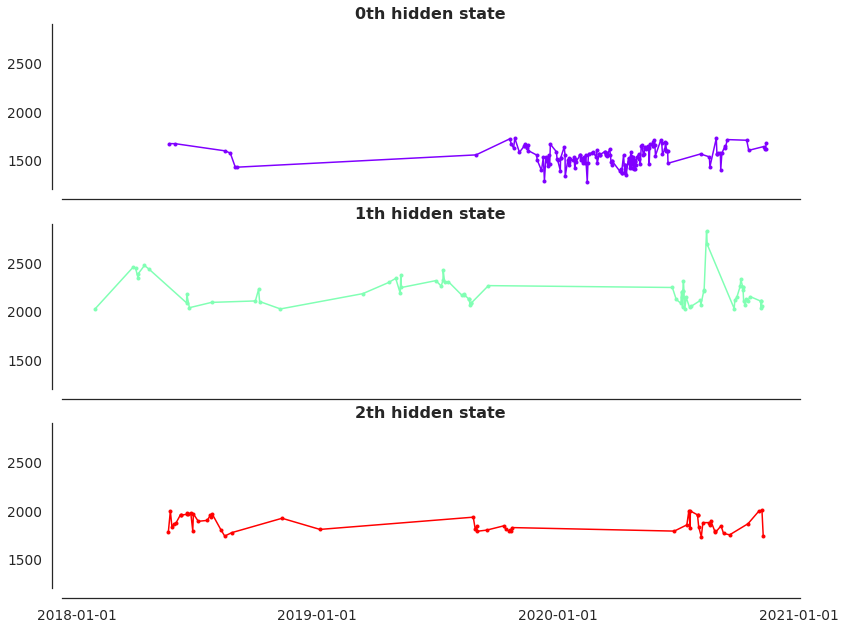

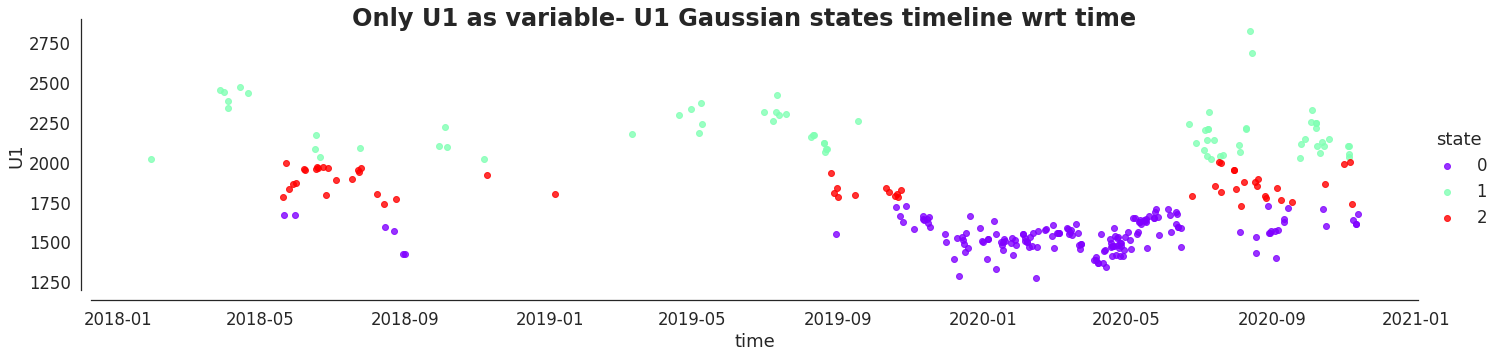

In [39]:
import sklearn.mixture as mix
col_names = ['U1']
X = new_df_sd_wc[col_names].values

# bgm = mix.BayesianGaussianMixture(n_components=3, n_init=10, random_state=42)
# bgm.fit(X)
# print(np.round(bgm.weights_, 2))
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
title = 'Only U1 as variable- U1 Gaussian states timeline wrt time '
markov_plot(new_df_sd_wc, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [1.99833923e+01 1.73864784e-01 4.22794614e+02 7.60954024e+00
 5.03009494e+03 2.62172289e+01 1.65091920e+03]
var =  [6.43443473e+01 1.67135568e-02 7.44159672e+03 1.86344606e-01
 5.90819007e+05 8.00617510e+02 5.12010637e+04]
1th hidden state
mean =  [1.83182757e+01 4.58329446e-01 3.38846560e+02 7.82179478e+00
 5.40319012e+03 8.69867564e+00 1.85055491e+03]
var =  [7.78521334e+01 2.67807847e-01 1.05276697e+04 1.51590013e-01
 1.84757932e+06 1.81439834e+01 7.85604301e+04]
2th hidden state
mean =  [1.96163886e+01 3.62870523e+00 2.86904701e+02 7.54214483e+00
 4.59279371e+03 1.28058543e+01 2.19853770e+03]
var =  [8.55777267e+01 5.15308141e+00 2.60895046e+04 1.50356762e-01
 2.23268127e+05 3.27396601e+02 8.72751667e+04]


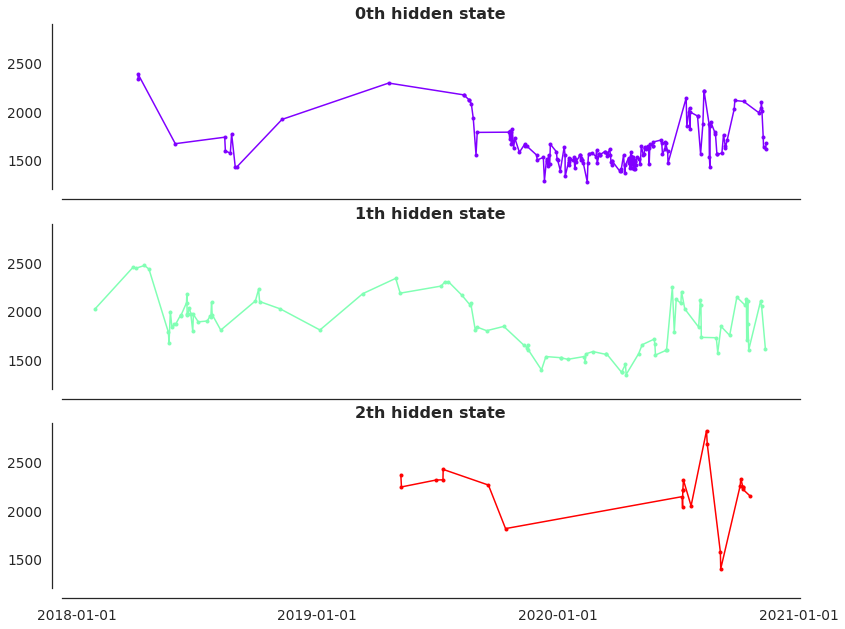

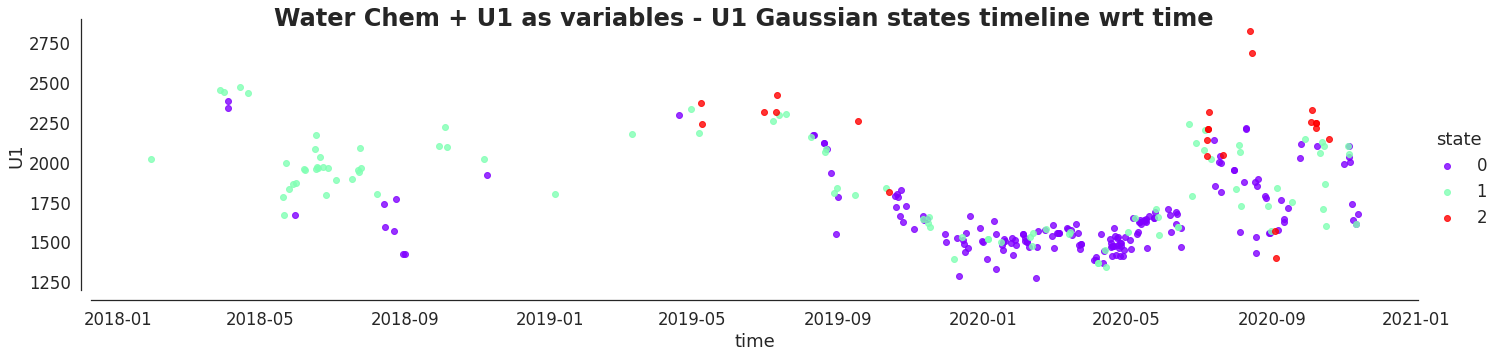

In [43]:
import sklearn.mixture as mix
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','U1']
X = new_df_sd_wc[col_names].values

# bgm = mix.BayesianGaussianMixture(n_components=3, n_init=10, random_state=42)
# bgm.fit(X)
# print(np.round(bgm.weights_, 2))
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
title = 'Water Chem + U1 as variables - U1 Gaussian states timeline wrt time '
markov_plot(new_df_sd_wc, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [1.81578102e+01 1.59130502e+00 2.97623672e+02 7.59692074e+00
 5.30902533e+03 9.32310052e+00 1.23161445e+02 5.87905438e-01
 1.98480812e+03]
var =  [8.36741744e+01 2.87101041e+00 1.56366121e+04 1.82808188e-01
 1.84679342e+06 2.70553348e+01 9.99169973e+00 4.48223342e+01
 1.13625527e+05]
1th hidden state
mean =  [ 1.96267202e+01  1.86010246e-01  4.09917596e+02  7.69975871e+00
  5.03326433e+03  2.15277163e+01  1.24011427e+02 -4.05911500e-01
  1.70636908e+03]
var =  [6.77348007e+01 1.83730410e-02 7.95592400e+03 1.86590835e-01
 8.12321461e+05 6.62068399e+02 1.57320879e+01 1.45285137e+01
 6.59943317e+04]
2th hidden state
mean =  [ 2.11730906e+01  1.47972964e+00  3.54629350e+02  7.64600331e+00
  5.67750579e+03  2.74834186e+01  1.24724426e+02 -4.18424228e+01
  1.63617022e+03]
var =  [5.90391226e+01 7.46424700e+00 2.04608540e+04 8.97339634e-02
 4.50916761e+05 9.11540563e+02 1.47270919e+01 1.79787671e+04
 3.88551909e+04]


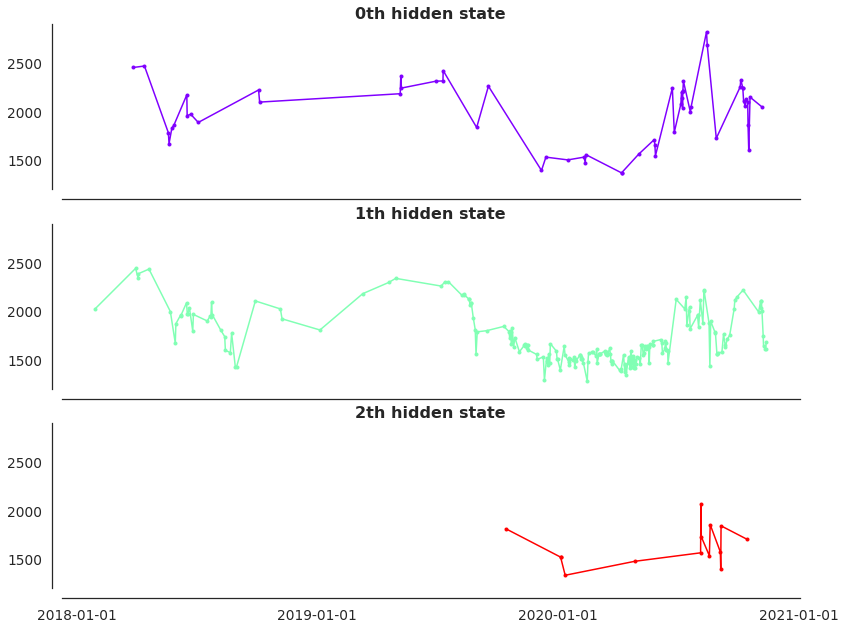

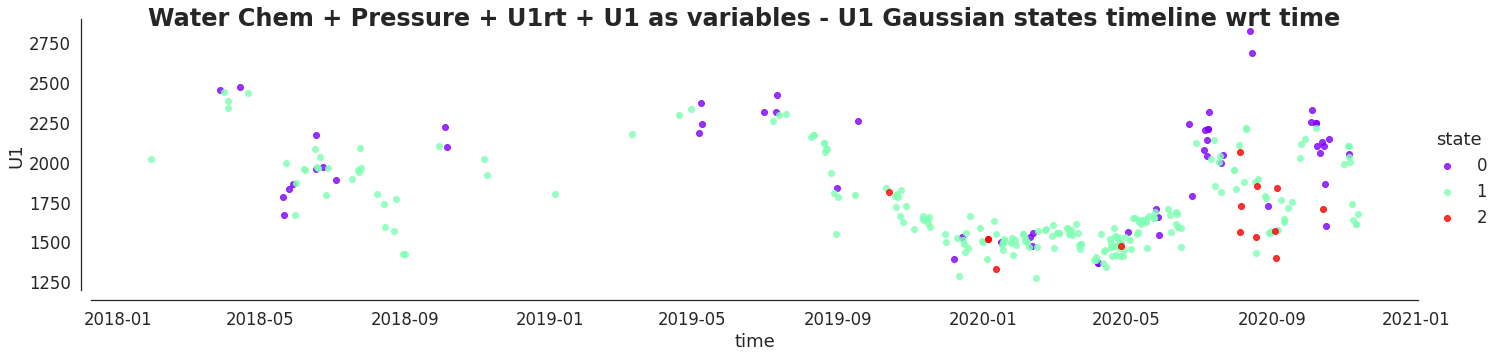

In [44]:
import sklearn.mixture as mix
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','U1rt', 'U1']
X = new_df_sd_wc[col_names].values

# bgm = mix.BayesianGaussianMixture(n_components=3, n_init=10, random_state=42)
# bgm.fit(X)
# print(np.round(bgm.weights_, 2))
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
title = 'Water Chem + Pressure + U1rt + U1 as variables - U1 Gaussian states timeline wrt time '
markov_plot(new_df_sd_wc, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [1.98558819e+01 1.67493836e-01 3.86489703e+02 7.67499460e+00
 5.20983452e+03 1.69108123e+01 3.18415908e+01 3.09921284e+01
 1.56961030e+03]
var =  [5.82706515e+01 1.44861631e-02 1.55290790e+04 1.78951126e-01
 8.21282722e+05 2.39682600e+02 2.49280466e+02 1.41710393e+03
 1.36350427e+04]
1th hidden state
mean =  [1.94309086e+01 1.13509124e+00 3.21648559e+02 7.58157312e+00
 5.13876296e+03 5.49177433e+01 4.12847687e+01 4.14409289e+01
 1.86730760e+03]
var =  [6.11025268e+01 3.97038769e+00 2.86047504e+04 1.53535544e-01
 9.06056568e+05 2.11619600e+03 2.34811141e+02 1.47792132e+03
 8.92626160e+04]
2th hidden state
mean =  [1.93218566e+01 1.25171372e+00 3.80213230e+02 7.52384610e+00
 5.36591299e+03 8.56209186e+00 2.92424499e+01 4.12333551e+01
 2.04970691e+03]
var =  [7.83470421e+01 2.78628734e+00 9.77562265e+03 2.13660127e-01
 1.16471536e+06 3.66233779e+01 5.66080777e+01 1.87270073e+03
 8.34842672e+04]


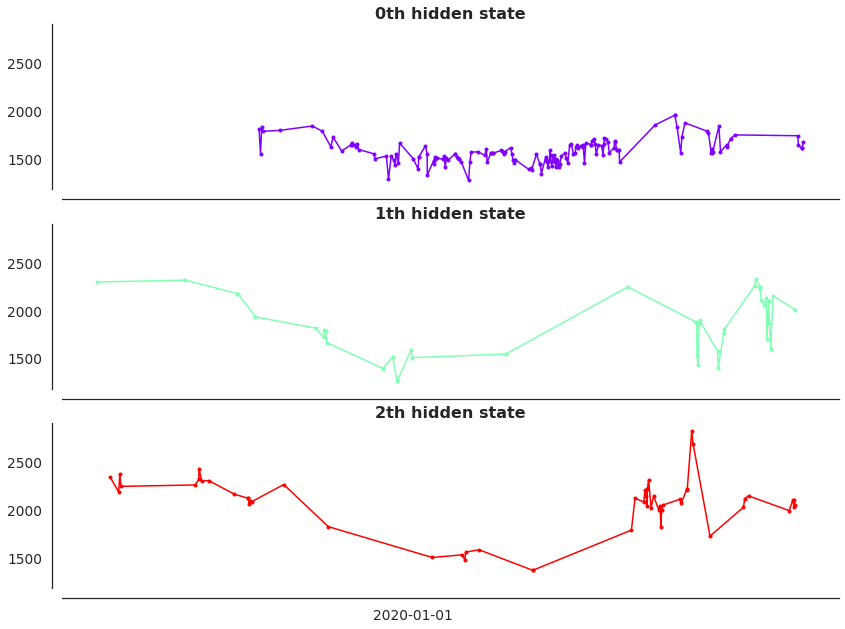

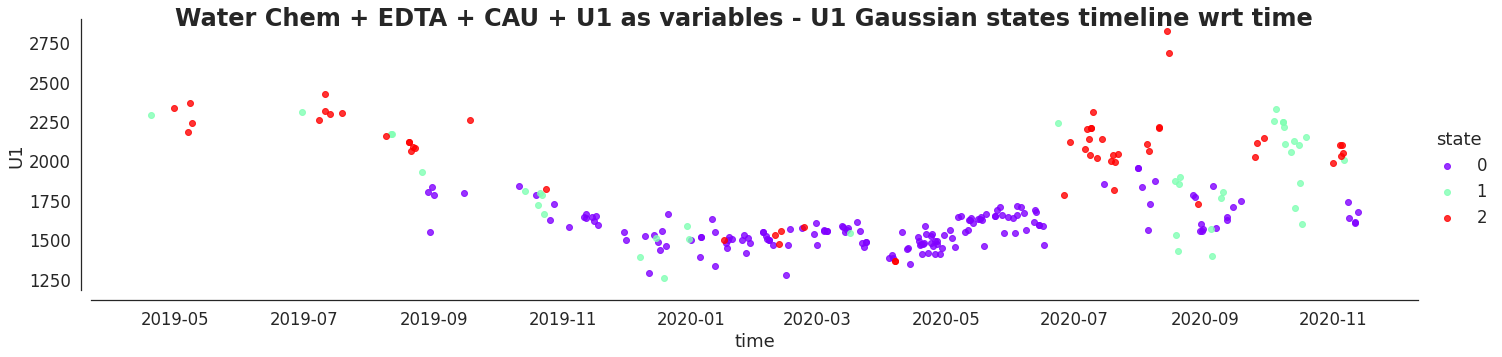

In [42]:
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','EDTA', 'CAU','U1']
X = new_df_sd_chem[col_names].values
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

title = 'Water Chem + EDTA + CAU + U1 as variables - U1 Gaussian states timeline wrt time '
markov_plot(new_df_sd_chem, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [ 1.89480529e+01  1.91519277e-01  4.33965149e+02  7.87292717e+00
  5.06093517e+03  2.02131513e+01  3.09687921e+01 -2.80819435e+00
  1.75662240e+03]
var =  [9.23444149e+01 1.36120897e-02 1.60776643e+04 3.52837590e-01
 1.24840079e+06 8.20049903e+02 2.12485775e+02 8.07866920e-02
 1.58596149e+05]
1th hidden state
mean =  [1.93848322e+01 3.40306979e-01 3.52492086e+02 7.50370543e+00
 5.66989375e+03 1.84827524e+01 3.49762605e+01 6.16056227e+01
 1.77452646e+03]
var =  [5.87919132e+01 2.01592020e-01 1.62740313e+04 3.18501840e-01
 2.77559147e+06 3.51806879e+02 2.23154056e+02 9.27838132e+02
 8.86275188e+04]
2th hidden state
mean =  [2.07355590e+01 4.27644216e+00 3.06949005e+02 7.75814433e+00
 4.71950904e+03 1.43602809e+01 2.62287855e+01 1.41434280e+01
 2.16220088e+03]
var =  [5.80407853e+01 1.73564970e+01 2.68292510e+04 2.53307335e-01
 2.03695958e+05 3.53327383e+02 8.36864327e+01 1.10466857e+03
 7.71878696e+04]


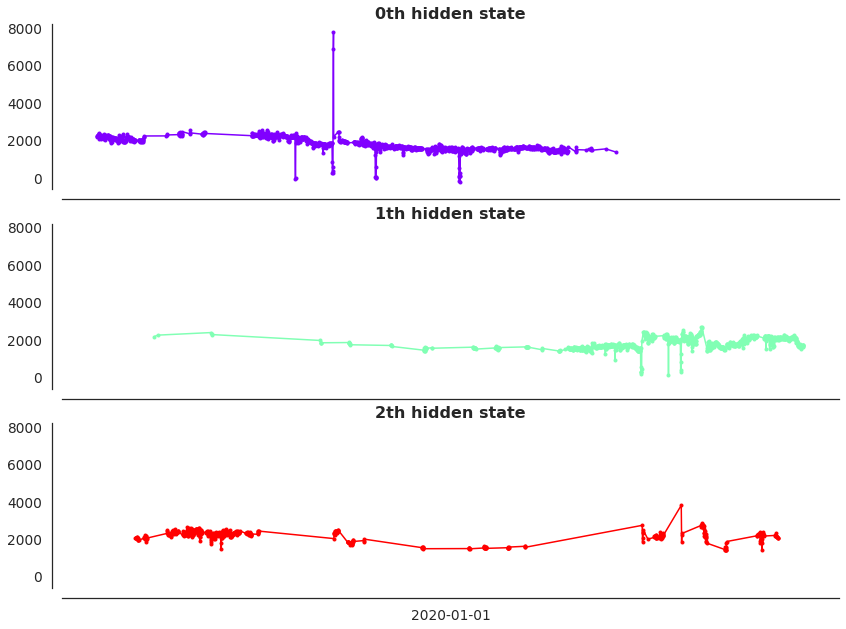

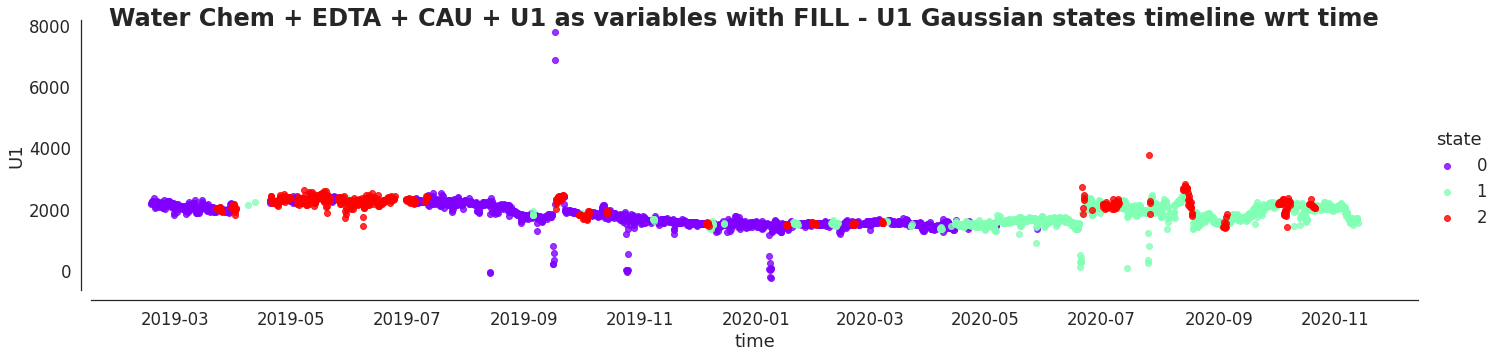

In [24]:
import sklearn.mixture as mix
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','EDTA', 'CAU','U1']
X = new_df_sd[col_names].values
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

title = 'Water Chem + EDTA + CAU + U1 as variables with FILL - U1 Gaussian states timeline wrt time '
markov_plot(new_df_sd, model, col_names, title)


In [25]:
!pip install hmmlearn

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
  Using cached hmmlearn-0.2.6-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (367 kB)
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


### Hidden Markov using Gaussian mixture

#### HMMGaussian Mixture on only U1 values

Means and vars of each hidden state
0th hidden state
mean =  [[2133.68908882]]
1th hidden state
mean =  [[1604.14307294]]
2th hidden state
mean =  [[1459.0623193]]


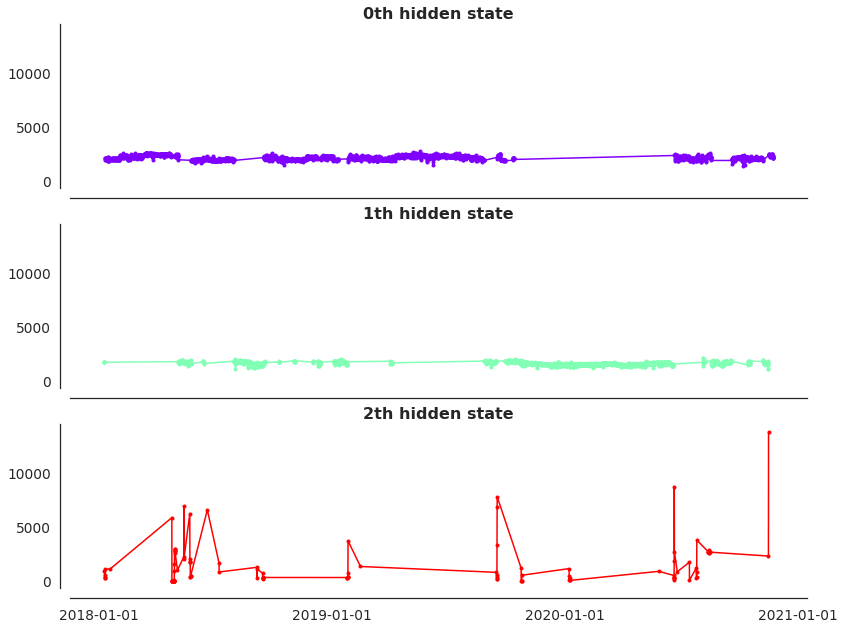

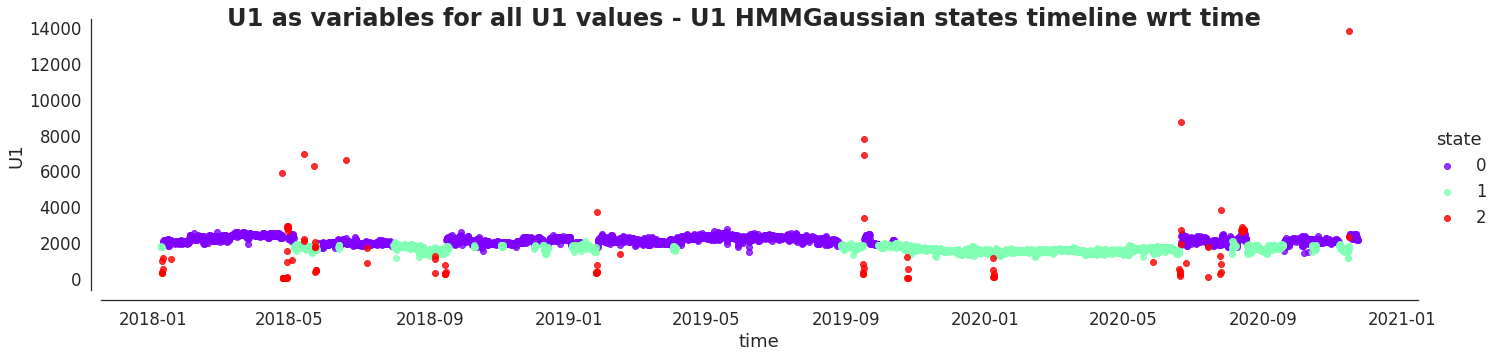

In [60]:
df_pos = df_evapuvalue_2018_wc[df_evapuvalue_2018_wc['U1']>0].copy()
df_pos = df_pos[['U1']] 
z_scores = zscore(df_pos)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2.5).all(axis=1)

new_df_pos = df_pos[filtered_entries].copy()
X = new_df_pos.values
model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X)
title = 'U1 as variables for all U1 values - U1 HMMGaussian states timeline wrt time '
markov_plot(new_df_pos, model, ['U1'], title)

#### HMMGaussian Mixture on only U1 values of new_df_sd_chem dataframe 

Means and vars of each hidden state
0th hidden state
mean =  [[2084.59541958]]
1th hidden state
mean =  [[1649.40585601]]
2th hidden state
mean =  [[1491.91036238]]


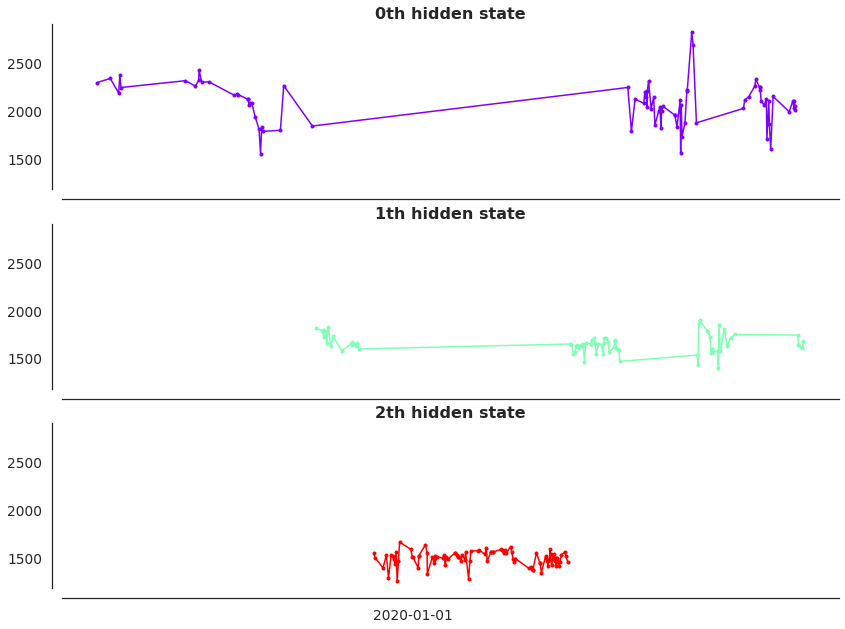

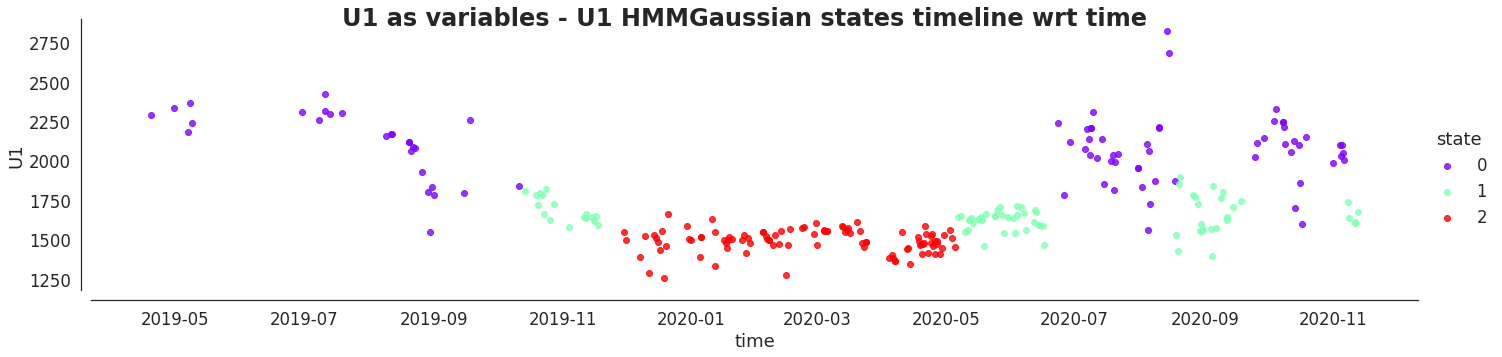

In [62]:
from hmmlearn import hmm
col_names = ['U1']
X = new_df_sd_chem[col_names].values

model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X)
title = 'U1 as variables - U1 HMMGaussian states timeline wrt time '
markov_plot(new_df_sd_chem, model, col_names, title)


#### HMMGaussian Mixture with other variables

Means and vars of each hidden state
0th hidden state
mean =  [[2.01458986e+01 2.73752607e+00 2.85930063e+02 7.48434864e+00
  4.91568988e+03 1.02415450e+01 2.05364449e+03]]
1th hidden state
mean =  [[2.02988587e+01 2.31572410e-01 4.30845584e+02 7.65759221e+00
  5.16030959e+03 4.18611784e+01 1.67248396e+03]]
2th hidden state
mean =  [[1.86998587e+01 2.28825735e-01 3.78479274e+02 7.72910699e+00
  5.14491417e+03 8.16084346e+00 1.74716210e+03]]


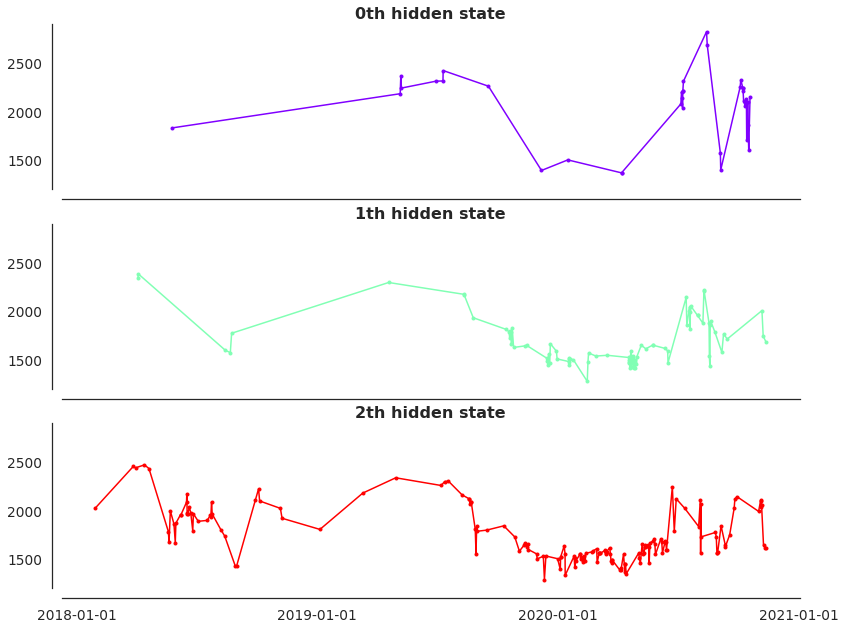

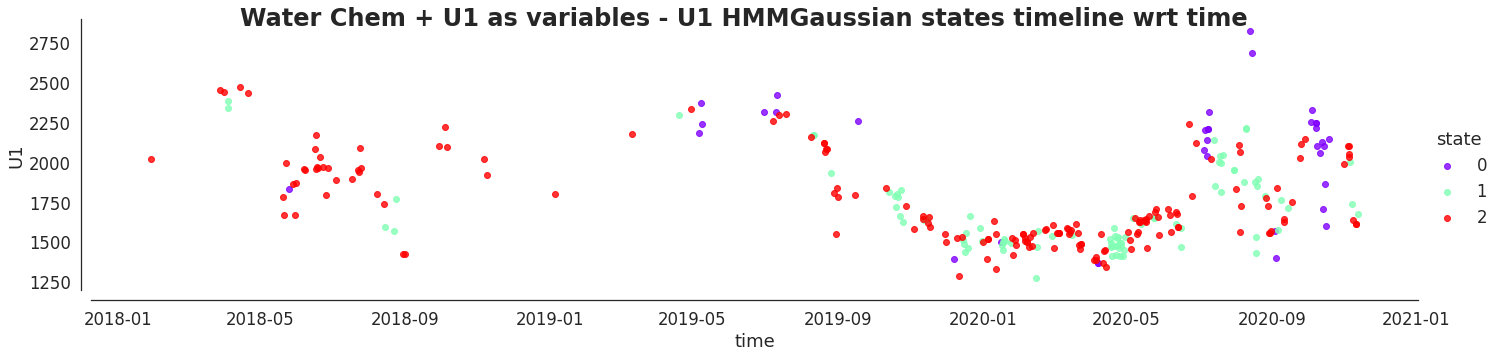

In [52]:
from hmmlearn import hmm
col_names_to_fit = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity']
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity', 'U1']
X = new_df_sd_wc[col_names_to_fit].values

model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X)
title = 'Water Chem + U1 as variables - U1 HMMGaussian states timeline wrt time '
markov_plot(new_df_sd_wc, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [[1.74502640e+01 1.60968637e+00 3.30878825e+02 7.72526590e+00
  4.61697692e+03 8.63666809e+00 1.24468028e+02 6.06775871e-01
  2.03617721e+03]]
1th hidden state
mean =  [[ 1.80469775e+01  5.54056721e-01  3.62294433e+02  7.56164448e+00
   5.84293318e+03  5.42156423e+01  1.22528513e+02 -2.15307299e+01
   1.70737894e+03]]
2th hidden state
mean =  [[ 2.02476123e+01  1.79682002e-01  4.04871225e+02  7.67612771e+00
   5.18329110e+03  1.76203821e+01  1.23866209e+02 -2.13306275e-01
   1.67674586e+03]]


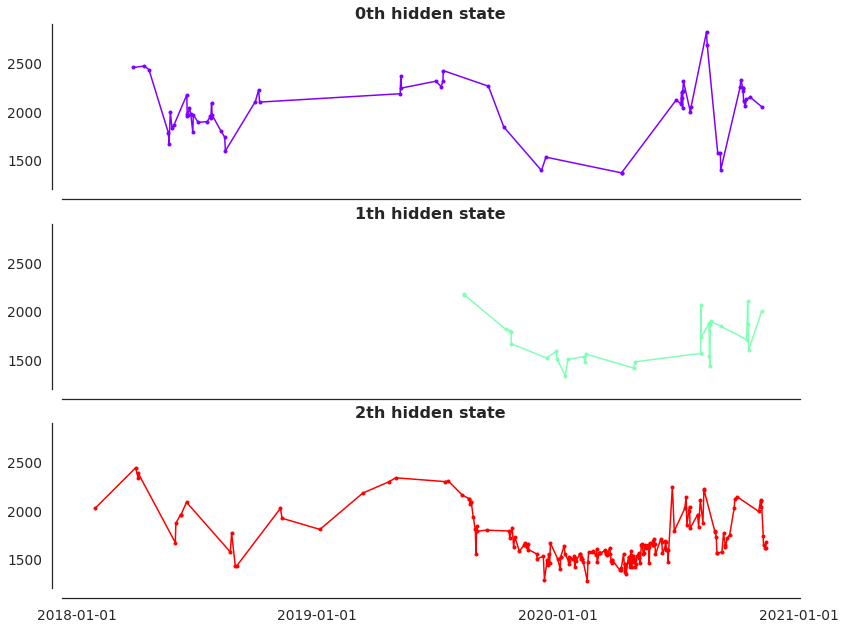

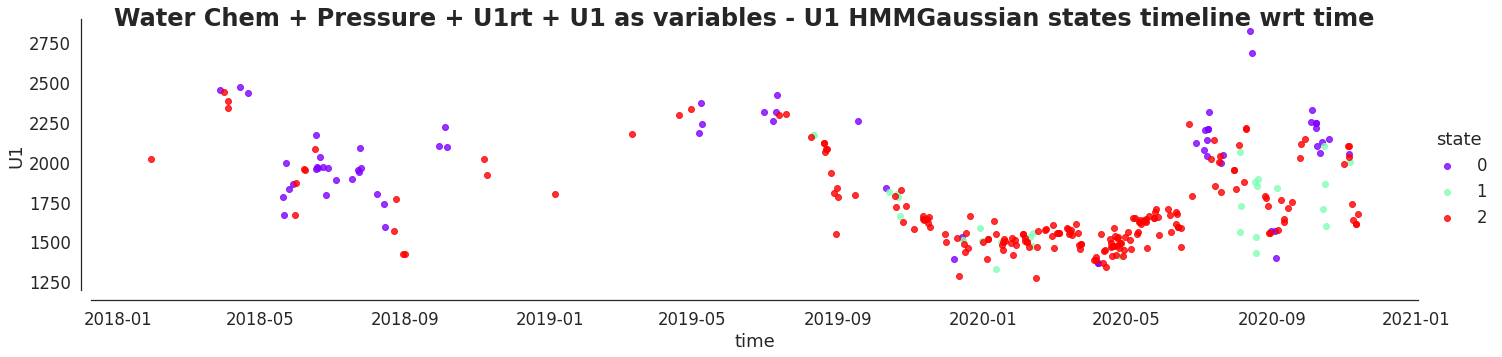

In [56]:
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','P1','U1rt', 'U1']
X = new_df_sd_wc[col_names].values

model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X)
title = 'Water Chem + Pressure + U1rt + U1 as variables - U1 HMMGaussian states timeline wrt time '
markov_plot(new_df_sd_wc, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [[2.00591342e+01 5.78630200e-01 3.69295771e+02 7.58884896e+00
  5.47889235e+03 4.02407237e+01 5.03062328e+01 2.43581426e+01
  1.68292752e+03]]
1th hidden state
mean =  [[1.96557560e+01 1.18725041e+00 3.25246917e+02 7.58650821e+00
  5.08699130e+03 9.53817155e+00 3.08489217e+01 5.18113710e+01
  2.05763643e+03]]
2th hidden state
mean =  [[1.94823755e+01 1.86641197e-01 4.06199419e+02 7.66966418e+00
  5.19227529e+03 1.82635908e+01 2.50228005e+01 3.04501932e+01
  1.54799287e+03]]


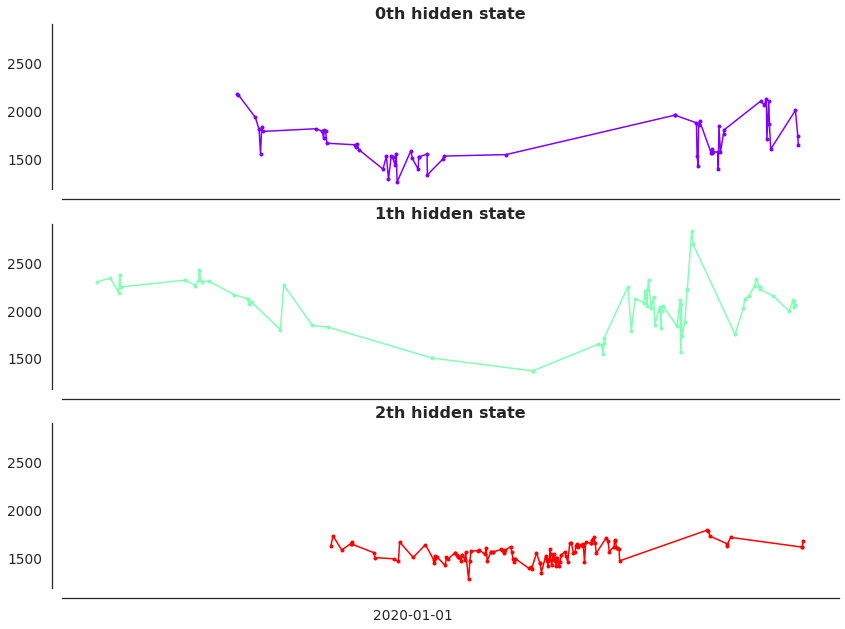

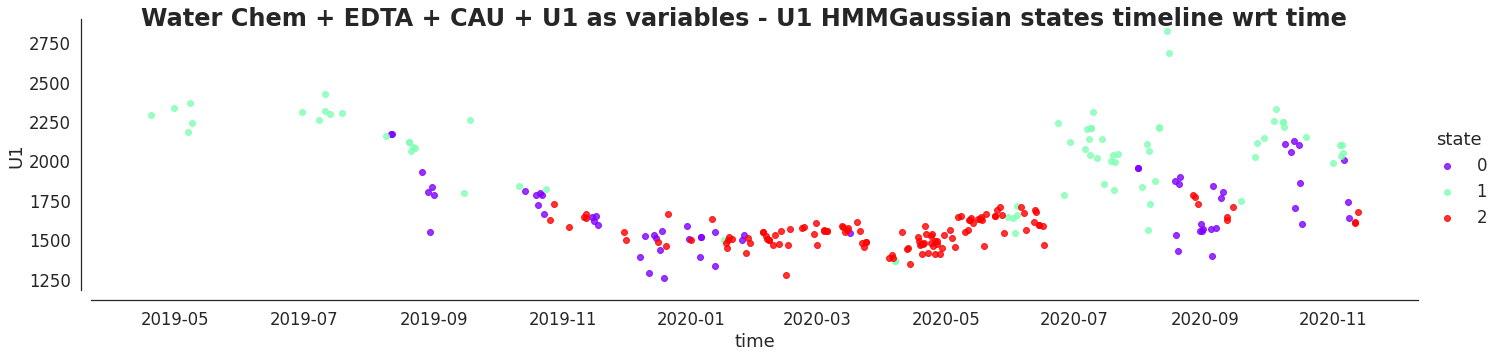

In [57]:
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity','EDTA', 'CAU','U1']
X = new_df_sd_chem[col_names].values
model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X)

title = 'Water Chem + EDTA + CAU + U1 as variables - U1 HMMGaussian states timeline wrt time '
markov_plot(new_df_sd_chem, model, col_names, title)


Means and vars of each hidden state
0th hidden state
mean =  [[1.93855879e+01 3.87393052e+00 3.09437912e+02 7.98626542e+00
  4.64136977e+03 1.48615537e+01]]
1th hidden state
mean =  [[1.82229125e+01 3.16449245e-01 3.92682657e+02 7.70053369e+00
  5.70633310e+03 7.74893952e+00]]
2th hidden state
mean =  [[2.05216401e+01 1.80551410e-01 4.12966857e+02 7.63190527e+00
  5.01260741e+03 3.01394800e+01]]


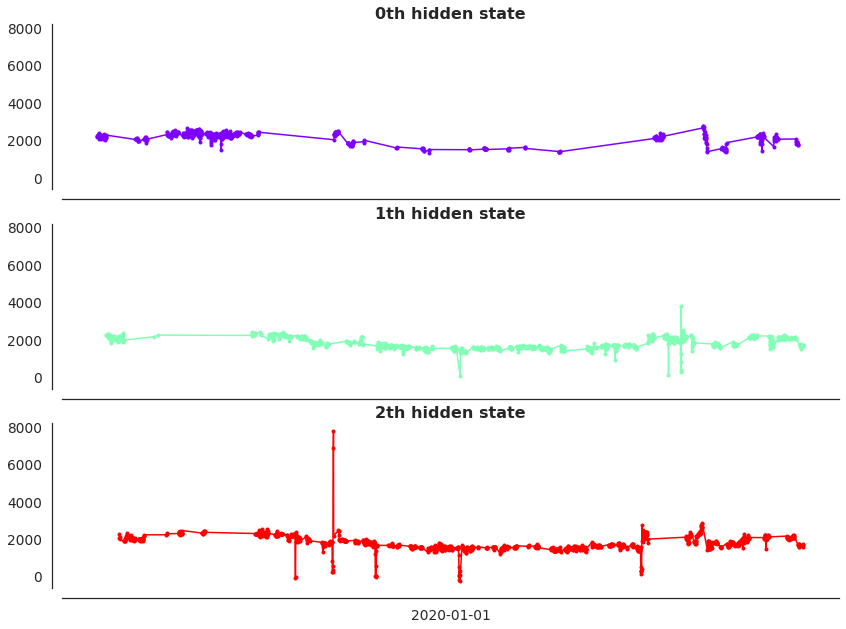

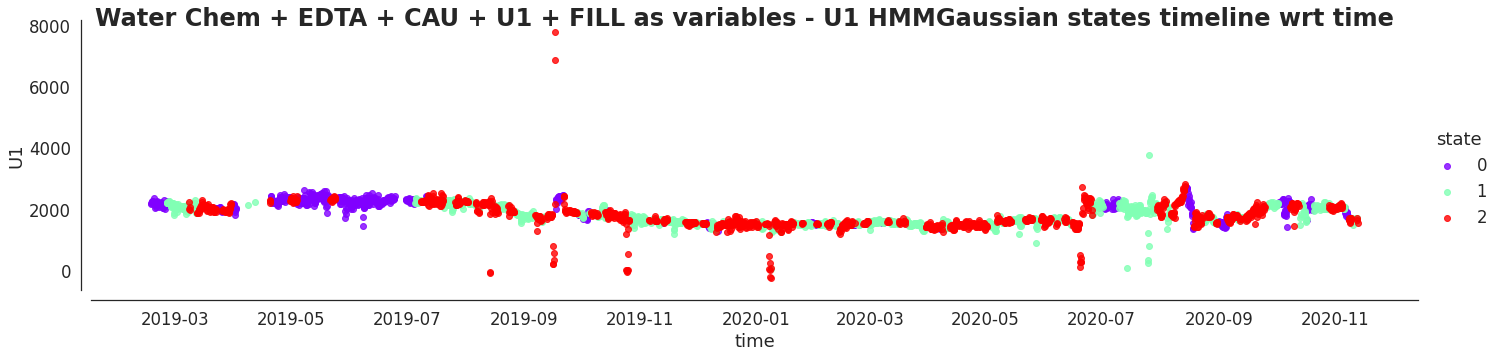

In [30]:
from hmmlearn import hmm
col_names_to_fit = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity']
col_names = ['hardness', 'iron', 'silica', 'ph', 'conductivity', 'turbidity', 'U1']
X = new_df_sd[col_names_to_fit].values
model = hmm.GMMHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X)

title = 'Water Chem + EDTA + CAU + U1 + FILL as variables - U1 HMMGaussian states timeline wrt time '
markov_plot(new_df_sd, model, col_names, title)
